# Perform t-SNE analysis for treatment naive samples using only protein coding genes

Script related to figure s1a

### Aim:
- See if by using only protein coding genes the patient-wise clustering is retained

In [1]:
!python --version

Python 3.6.8 :: Anaconda custom (64-bit)


## Import packages

In [1]:
import pyensembl
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.manifold as tsne
import matplotlib.pyplot as plt

In [2]:
home = "~/git_repos/HGSOC_TME_Heterogeneity/" # home

## Get sample labels

### Load file

In [5]:
file_keys = home + "Data/1/TreatmentNaive_SampleLabels_WESTumourCellularity.txt"

sample_labels = pd.read_csv(file_keys, sep='\t', index_col='Well')

In [6]:
sample_labels.head()

,Label,Key,Case_mRNA,Site,Habitat,Case_WES,Tumour_WES,Colour,Site_marker,TumourCellularity_WES
Well,,,,,,,,,,
A01,A01_3640_5_Omentum,case10_omentum_green,10,omentum,green,10.0,5,#ff7f00,^,0.5973
A02,A02_3640_7_Omentum,case10_omentum_blue,10,omentum,blue,10.0,7,#ff7f00,^,0.5065
A03,A03_3640_9_Paracolic_Gutter,case10_paracolic_yellow,10,other,yellow,10.0,8,#ff7f00,s,0.4551
A04,A04_3640_17_R_Adnexa,case10_Radnexa_yellow,10,ovary,yellow,10.0,17,#ff7f00,o,0.6496
A05,A05_3640_18_R_Adnexa,case10_Radnexa_blue,10,ovary,blue,10.0,18,#ff7f00,o,0.6706


### Define sample colours

In [7]:
case_mrna = list(set(sample_labels['Case_mRNA']))

colours = sns.color_palette("Set1", 8).as_hex()

sample_labels['Colour'] = sample_labels['Case_mRNA'].replace(case_mrna, colours)

### Define sample markers

In [8]:
sites = ['ovary','omentum','other']
markers = ['o','^','s']

sample_labels['Site_marker'] = sample_labels['Site'].replace(sites,markers)

In [9]:
sample_labels.head()

,Label,Key,Case_mRNA,Site,Habitat,Case_WES,Tumour_WES,Colour,Site_marker,TumourCellularity_WES
Well,,,,,,,,,,
A01,A01_3640_5_Omentum,case10_omentum_green,10,omentum,green,10.0,5,#ff7f00,^,0.5973
A02,A02_3640_7_Omentum,case10_omentum_blue,10,omentum,blue,10.0,7,#ff7f00,^,0.5065
A03,A03_3640_9_Paracolic_Gutter,case10_paracolic_yellow,10,other,yellow,10.0,8,#ff7f00,s,0.4551
A04,A04_3640_17_R_Adnexa,case10_Radnexa_yellow,10,ovary,yellow,10.0,17,#ff7f00,o,0.6496
A05,A05_3640_18_R_Adnexa,case10_Radnexa_blue,10,ovary,blue,10.0,18,#ff7f00,o,0.6706


## Load expression data

In [10]:
data_file = home + "Data/1/TreatmentNaive_log2exp_loess_norm.txt"

data = pd.read_csv(data_file, sep='\t', index_col='Hugo_Symbol')

In [11]:
data.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,C06,C07,C08,C09,C10,C11,C12,D01,D02,D03
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,4.124711,3.880633,4.864973,4.167882,4.317845,3.679057,4.092837,4.370571,4.252637,4.174694,...,3.804537,4.416981,4.169014,4.503313,4.146333,4.078398,4.011369,3.845128,3.600927,4.521857
A2BP1,3.960924,4.033715,3.721251,3.916073,4.338194,3.357396,3.872447,3.803388,3.484735,4.427405,...,4.991068,3.799913,4.117883,4.122134,4.221760,3.648326,3.675317,3.546925,3.788279,4.920841
A2M,12.603155,10.859838,12.612923,9.176999,10.548790,11.840776,7.200547,11.835658,11.535547,7.080118,...,9.061598,9.189459,8.844728,7.464440,6.726233,9.265911,10.740486,9.735582,10.781599,8.734304
A2ML1,3.945877,4.000621,3.767932,3.789729,3.543204,3.805520,4.336280,4.031757,4.166018,3.673146,...,4.231174,3.871651,3.287232,3.721093,3.723801,3.884499,3.694111,3.937682,3.600471,3.402861
A4GALT,3.597277,3.863757,4.051844,4.113169,3.975144,3.991293,5.439960,4.696177,4.171788,4.041633,...,4.183089,4.699729,4.019537,3.739865,4.591953,4.997860,4.099630,5.001239,4.714710,4.145119


## Filter-out non-protein coding genes

### Select ensembl release

In [12]:
ensembl = pyensembl.EnsemblRelease(release=75)
genes = ensembl.genes() # genes object

### Filter-in protein coding genes

In [13]:
prot_cod_genes = []
for gene in genes:
    
    if gene.biotype == 'protein_coding':
        
        prot_cod_genes.append(str(gene.name))

In [14]:
prot_cod_genes[:5]

['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

In [15]:
len(prot_cod_genes)

22810

In [16]:
data_protCod = data[data.index.isin(set(prot_cod_genes))]

### What fraction of genes do we retain?

In [17]:
len(data_protCod.index) / len(data.index)

0.985001363512408

## Calculate t-SNE

### Transpose data frame

In [18]:
data_protCod.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,C06,C07,C08,C09,C10,C11,C12,D01,D02,D03
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,4.124711,3.880633,4.864973,4.167882,4.317845,3.679057,4.092837,4.370571,4.252637,4.174694,...,3.804537,4.416981,4.169014,4.503313,4.146333,4.078398,4.011369,3.845128,3.600927,4.521857
A2M,12.603155,10.859838,12.612923,9.176999,10.548790,11.840776,7.200547,11.835658,11.535547,7.080118,...,9.061598,9.189459,8.844728,7.464440,6.726233,9.265911,10.740486,9.735582,10.781599,8.734304
A2ML1,3.945877,4.000621,3.767932,3.789729,3.543204,3.805520,4.336280,4.031757,4.166018,3.673146,...,4.231174,3.871651,3.287232,3.721093,3.723801,3.884499,3.694111,3.937682,3.600471,3.402861
A4GALT,3.597277,3.863757,4.051844,4.113169,3.975144,3.991293,5.439960,4.696177,4.171788,4.041633,...,4.183089,4.699729,4.019537,3.739865,4.591953,4.997860,4.099630,5.001239,4.714710,4.145119
A4GNT,3.714481,3.593169,3.241352,3.515850,3.364447,3.767865,3.768695,3.163977,3.423377,3.205154,...,3.896812,3.915653,3.351422,3.719759,3.641028,3.114521,3.560199,3.539738,3.760903,3.479266


In [19]:
data_protCod_t = data_protCod.T

In [20]:
data_protCod_tsne = tsne.TSNE(learning_rate=100,
                              n_iter=5000,
                              perplexity=5).fit_transform(data_protCod_t.values)

## Plot t-SNE

### Create custom colormaps (a.k.a. cmaps)

In [21]:
def make_cmap(colors, position=None, bit=False):
    
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    
    return cmap

### Convert hex to rgb colour

In [22]:
def hex_to_rgb(value):
    
    '''Return (red, green, blue) for the color given as #rrggbb.'''
    
    value = value.lstrip('#')
    lv = len(value)
    
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

### Define cmaps for patient kernel densities

In [23]:
white = (255,255,255)

reds    = make_cmap([white, hex_to_rgb('#e41a1c')], bit=True)
blues   = make_cmap([white, hex_to_rgb('#377eb8')], bit=True)
greens  = make_cmap([white, hex_to_rgb('#4eae4b')], bit=True)
purples = make_cmap([white, hex_to_rgb('#994fa1')], bit=True)
oranges = make_cmap([white, hex_to_rgb('#ff8101')], bit=True)
yellows = make_cmap([white, hex_to_rgb('#fdfc33')], bit=True)
browns  = make_cmap([white, hex_to_rgb('#a8572c')], bit=True)
pinks   = make_cmap([white, hex_to_rgb('#f482be')], bit=True)

reds_r    = make_cmap([hex_to_rgb('#e41a1c'), white], bit=True)
blues_r   = make_cmap([hex_to_rgb('#377eb8'), white], bit=True)
greens_r  = make_cmap([hex_to_rgb('#4eae4b'), white], bit=True)
purples_r = make_cmap([hex_to_rgb('#994fa1'), white], bit=True)
oranges_r = make_cmap([hex_to_rgb('#ff8101'), white], bit=True)
yellows_r = make_cmap([hex_to_rgb('#fdfc33'), white], bit=True)
browns_r  = make_cmap([hex_to_rgb('#a8572c'), white], bit=True)
pinks_r   = make_cmap([hex_to_rgb('#f482be'), white], bit=True)

### Colour-sample correspondence

In [24]:
color_case_d = {1:reds,
                4:blues,
                5:greens,
                6:purples,
                10:oranges,
                13:yellows,
                16:browns,
                17:pinks}

color_case_dr = {1:reds_r,
                 4:blues_r,
                 5:greens_r,
                 6:purples_r,
                 10:oranges_r,
                 13:yellows_r,
                 16:browns_r,
                 17:pinks_r}

### Plot

(-300, 300)

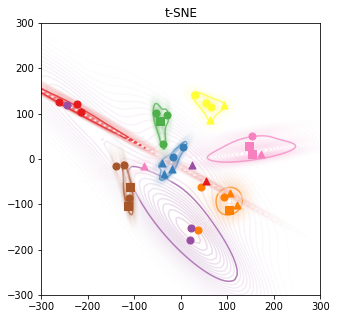

In [25]:
fig = plt.figure(figsize=(5, 5))

plt.title('t-SNE')

d_kde = {}
for i in range(len(data_protCod_tsne[:, 0])):
    
    plt.scatter(data_protCod_tsne[:, 0][i],
                data_protCod_tsne[:, 1][i],
                c=list(sample_labels['Colour'])[i],
                edgecolors=list(sample_labels['Colour'])[i],
                marker=list(sample_labels['Site_marker'])[i],
                zorder=1,
                lw=1,
                s=50)
    
    if list(sample_labels['Case_mRNA'])[i] not in d_kde:
        
        d_kde[list(sample_labels['Case_mRNA'])[i]] = {'x':[data_protCod_tsne[:, 0][i]],
                                                      'y':[data_protCod_tsne[:, 1][i]],
                                                      'c':list(sample_labels['Colour'])[i]}
    else:
        
        d_kde[list(sample_labels['Case_mRNA'])[i]]['x'].append(data_protCod_tsne[:, 0][i])
        d_kde[list(sample_labels['Case_mRNA'])[i]]['y'].append(data_protCod_tsne[:, 1][i])
      
for j in d_kde:

    sns.kdeplot(np.array(d_kde[j]['x']),
                np.array(d_kde[j]['y']),
                cmap=color_case_d[j],
                n_levels=27,
                alpha=.2,
                zorder=0,
                cut=3)
   
    sns.kdeplot(np.array(d_kde[j]['x']),
                np.array(d_kde[j]['y']), 
                cmap=color_case_dr[j],
                n_levels=1,
                alpha=.7,
                zorder=0,
                cut=3)
    
plt.xlim(-300,300)    
plt.ylim(-300,300) 

### Save plot

In [26]:
ls ../../Figures/supplementary/1/

OVCT_Fig_s1.pdf  OVCT_Fig_s1.png  README.md        panels/


In [27]:
FILE = "../../Figures/supplementary/1/panels/s1a_TreatmentNaive_proteinCod_tSNE.pdf"

fig.savefig(FILE, bbox='tight')

# End of script